In [1]:
import pandas as pd
import jax.numpy as np
import fuzzywuzzy.fuzz
import sklearn.cluster

In [2]:
import pathlib
import tqdm.notebook as tqdm

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
DATA_DIR = pathlib.Path('./data')

In [5]:
book_tags = pd.read_csv(DATA_DIR / 'book_tags.csv')
books = pd.read_csv(DATA_DIR / 'books.csv')
ratings = pd.read_csv(DATA_DIR / 'ratings.csv')
tags = pd.read_csv(DATA_DIR / 'tags.csv')
to_read = pd.read_csv(DATA_DIR / 'to_read.csv')

In [6]:
books.columns

Index(['book_id', 'goodreads_book_id', 'best_book_id', 'work_id',
       'books_count', 'isbn', 'isbn13', 'authors', 'original_publication_year',
       'original_title', 'title', 'language_code', 'average_rating',
       'ratings_count', 'work_ratings_count', 'work_text_reviews_count',
       'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5',
       'image_url', 'small_image_url'],
      dtype='object')

# Clean Tags

In [10]:
# tags that at least 100 people have given to a any book
useful_tag_ids = book_tags[
    book_tags['count'] > 100]['tag_id'].unique()

In [11]:
filtered_tags = tags[tags['tag_id'].isin(useful_tag_ids)]

In [12]:
tagged_books = book_tags.join(
    filtered_tags,
    on='tag_id',
    rsuffix='_user'
).dropna().drop(['tag_id', 'tag_id_user'], axis=1)

In [13]:
tag_usage_counts = tagged_books.groupby(
    'tag_name'
)['goodreads_book_id'].count()

percs = tag_usage_counts.describe(
    percentiles=[0.01, 0.05, .25, .50, .75, .95, .99]).loc[['25%', '99%']]

bottom = percs['25%']
top = percs['99%']

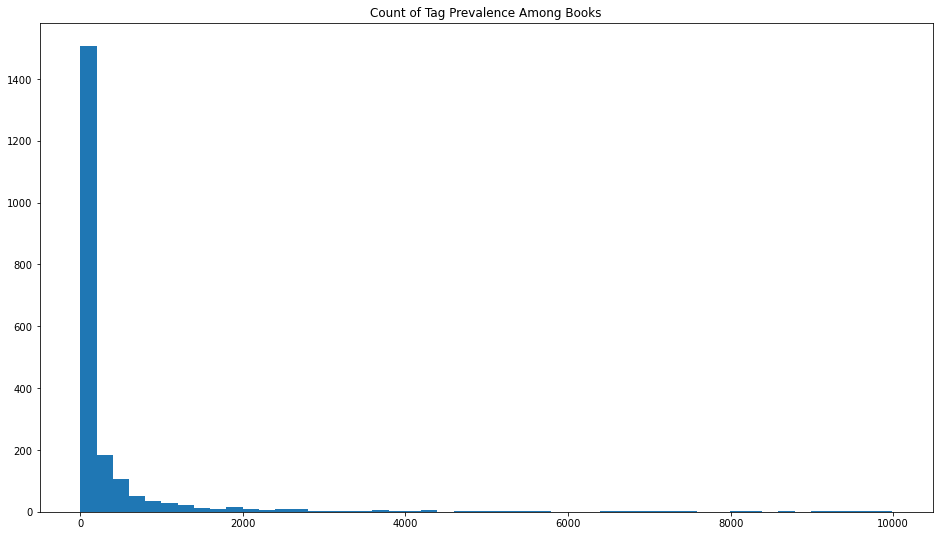

In [14]:
fig, ax = plt.subplots(figsize=(16,9))
ax.hist(
    tag_usage_counts, bins=50)
ax.set_title('Count of Tag Prevalence Among Books');

In [15]:
useful_tag_list = tag_usage_counts[
    (tag_usage_counts > bottom) &
    (tag_usage_counts < top)].index.tolist()
# cluster tags based on fuzzy matching

# Clustering on Fuzz Ratio

In [14]:
pairwise_fuzz = np.zeros(
    (len(useful_tag_list), len(useful_tag_list)))

In [16]:
pairwise_fuzz = np.load(DATA_DIR / 'pairwise_fuzz.npy')

In [195]:
for i, ltag in tqdm.tqdm(
        enumerate(useful_tag_list),
        total=len(useful_tag_list)):
    for j, rtag in enumerate(useful_tag_list):
        pairwise_fuzz = pairwise_fuzz.at[i, j].set(
            fuzzywuzzy.fuzz.ratio(ltag, rtag))

# hierarchical clustering based on fuzz ratio

  0%|          | 0/1524 [00:00<?, ?it/s]

In [ ]:
np.save(DATA_DIR / 'pairwise_fuzz', pairwise_fuzz)

In [17]:
hierarchy_clusters = sklearn.cluster.AgglomerativeClustering(
    n_clusters=15,
    linkage='ward')
    

In [18]:
hierarchy_clusters.fit(pairwise_fuzz)

AgglomerativeClustering(n_clusters=15)

In [19]:
pairwise_fuzz

DeviceArray([[100.,   0.,  24., ...,  29.,   0.,   0.],
             [  0., 100.,  29., ...,   0.,   0.,   0.],
             [ 24.,  29., 100., ...,  25.,   0.,   0.],
             ...,
             [ 29.,   0.,  25., ..., 100.,   0.,   0.],
             [  0.,   0.,   0., ...,   0., 100.,  22.],
             [  0.,   0.,   0., ...,   0.,  22., 100.]], dtype=float32)

/home/mmargenot/miniconda3/envs/virgil/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


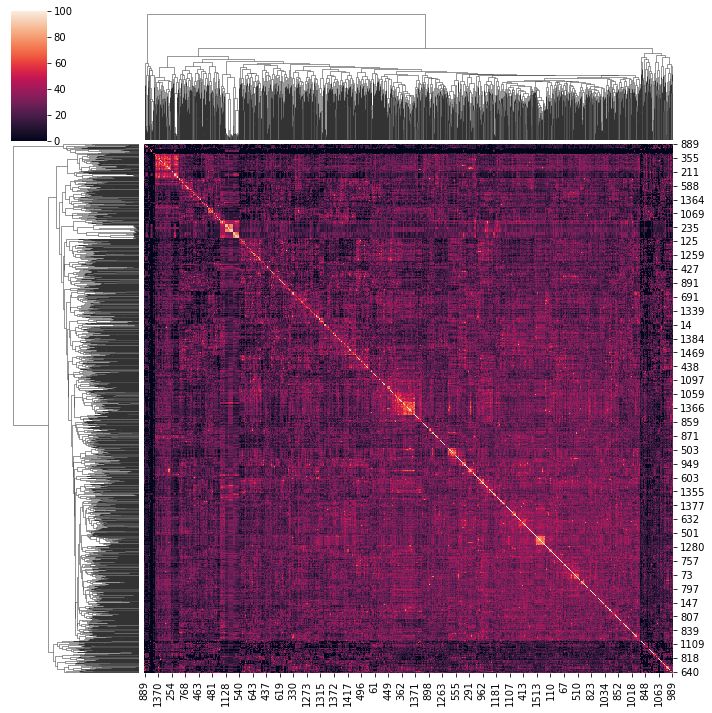

In [20]:
sns.clustermap(pairwise_fuzz);

In [21]:
clustered_tags = pd.Series(index=useful_tag_list, data=hierarchy_clusters.labels_)  # mix in hierarchy labels to tag_counts

In [22]:
book_tag_counts = tagged_books.drop_duplicates(
    subset=['goodreads_book_id', 'tag_name']
).pivot(index='goodreads_book_id', columns='tag_name', values='count').fillna(0.0)

In [23]:
full_joined_book_data = books.join(book_tag_counts, on='goodreads_book_id', rsuffix='_r')

In [24]:
english_filter = full_joined_book_data['language_code'].str.contains('en').fillna(True)

In [25]:
full_joined_book_data = full_joined_book_data[english_filter].dropna(
    subset=['title', 'original_publication_year'])

In [26]:
tag_columns = book_tag_counts.columns.tolist()
id_columns = ['book_id', 'goodreads_book_id', 'best_book_id', 'work_id', 'isbn', 'isbn13']
rating_columns = [
    'average_rating', 'ratings_count', 'work_ratings_count', 'work_text_reviews_count']
    #'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5']
author_dummies = pd.get_dummies(full_joined_book_data['authors'], prefix='author')
decade = (full_joined_book_data['original_publication_year'] // 10 * 10).astype(int)
decade_dummies = pd.get_dummies(decade, prefix='decade')

In [27]:
complete_book_data = pd.concat([
    full_joined_book_data.dropna(
        subset=['title', 'original_publication_year']),
    author_dummies,
    decade_dummies],
    axis=1)

In [28]:
modeling_columns = (
    author_dummies.columns.tolist() +
    decade_dummies.columns.tolist() +
    tag_columns + ['average_rating'])

In [29]:
modeling_data = complete_book_data[modeling_columns]

## More tag cleaning

In [86]:
special_shelves = ['to-read', 'currently-reading', 'kindle', 'audio']

In [87]:
tag_indicators = X[tag_columns].astype(bool)

In [88]:
tag_counts = X[tag_columns]

In [89]:
tag_indicators.corrwith(y).describe(
    percentiles=[0.01, 0.05, 0.15, 0.25, 0.50, 0.75, 0.85, 0.95, 0.99])

count    2049.000000
mean        0.001888
std         0.061619
min        -0.351217
1%         -0.205604
5%         -0.089892
15%        -0.036448
25%        -0.019193
50%         0.001082
75%         0.024750
85%         0.046883
95%         0.099834
99%         0.177421
max         0.353714
dtype: float64

In [90]:
tag_counts.corrwith(y).describe(
    percentiles=[0.01, 0.05, 0.15, 0.25, 0.50, 0.75, 0.85, 0.95, 0.99])

count    2049.000000
mean        0.007184
std         0.038147
min        -0.173242
1%         -0.100232
5%         -0.046999
15%        -0.022684
25%        -0.011637
50%         0.003847
75%         0.023687
85%         0.039249
95%         0.075680
99%         0.120637
max         0.200341
dtype: float64

In [75]:
high_indicator_correlation = tag_indicators.corrwith(y)[
    tag_indicators.corrwith(y).abs() > 0.15
].index.tolist()

In [73]:
high_count_correlation = tag_indicators.corrwith(y)[
    tag_counts.corrwith(y).abs() > 0.15
].index.tolist()

In [92]:
extra_tags_to_remove = high_count_correlation + special_shelves

### Tag Indicator Analysis - not super conclusive

In [79]:
tag_indicator_analysis_df = pd.concat([y, tag_indicators], axis=1)

In [82]:
tag_indicator_analysis_df.groupby('5-star')['average_rating'].mean()

5-star
False    3.985710
True     4.269158
Name: average_rating, dtype: float64

In [83]:
tag_indicator_analysis_df.groupby('5-stars')['average_rating'].mean()

5-stars
False    3.949668
True     4.153324
Name: average_rating, dtype: float64

# Final Dataset

In [100]:
final_columns = list(filter(
    lambda x: not x == 'average_rating',
    filter(lambda x: not x in extra_tags_to_remove, modeling_columns)))

In [101]:
y = modeling_data['average_rating']
X = modeling_data[final_columns]

# Quick Modelling

## Classifier

In [118]:
import sklearn.ensemble

In [127]:
model = sklearn.ensemble.RandomForestClassifier()

In [128]:
model.fit(X, y.round().astype(int))

RandomForestClassifier()

In [129]:
print(sklearn.metrics.classification_report(
    y.round().astype(int), model.predict(X)))

              precision    recall  f1-score   support

           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00       321
           4       1.00      1.00      1.00      9349
           5       1.00      1.00      1.00       123

    accuracy                           1.00      9794
   macro avg       1.00      1.00      1.00      9794
weighted avg       1.00      1.00      1.00      9794



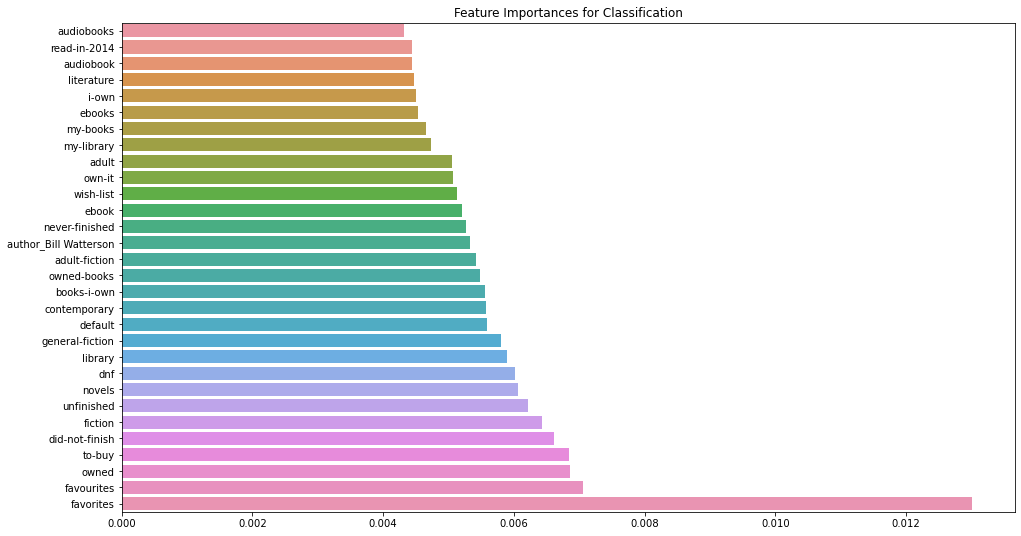

In [132]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.barplot(
    y=np.array(final_columns)[np.argsort(model.feature_importances_)[-30:]],
    x=model.feature_importances_[np.argsort(model.feature_importances_)[-30:]],
    ax=ax);
ax.set_title('Feature Importances for Classification');
# good first set to remove?

In [133]:
classifier_top_features = np.array(
    final_columns
)[np.argsort(model.feature_importances_)[-30:]].tolist()

In [138]:
even_more_bad_tags = list(
    filter(lambda x: not 'author' in x, classifier_top_features))

## Regressor

In [143]:
X_new = X[list(filter(lambda x: not x in even_more_bad_tags, X.columns))]

In [106]:
import numpy as np

In [144]:
model = sklearn.ensemble.RandomForestRegressor()

In [145]:
model.fit(X_new, y)

RandomForestRegressor()

In [147]:
print(
    sklearn.metrics.r2_score(
        y, model.predict(X_new)))

0.9459360968053988


In [148]:
print(
    sklearn.metrics.r2_score(
        y, model.predict(X_new)))

0.9459360968053988


In [149]:
print(
    sklearn.metrics.max_error(
        y, model.predict(X_new)))

0.4247999999999963


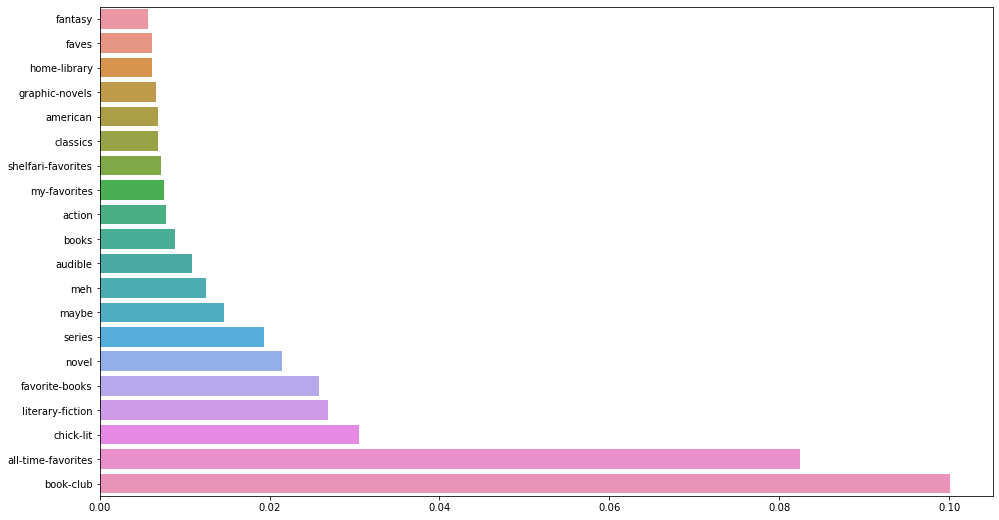

In [150]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.barplot(
    y=np.array(X_new.columns)[np.argsort(model.feature_importances_)[-20:]],
    x=model.feature_importances_[np.argsort(model.feature_igithub.commportances_)[-20:]],
    ax=ax);

# Dim-Reduction

In [152]:
import sklearn.decomposition

In [157]:
# data is mixed so should probably separate
dim_red = sklearn.decomposition.PCA(
    n_components=2)

pca_space = dim_red.fit_transform(X_new)

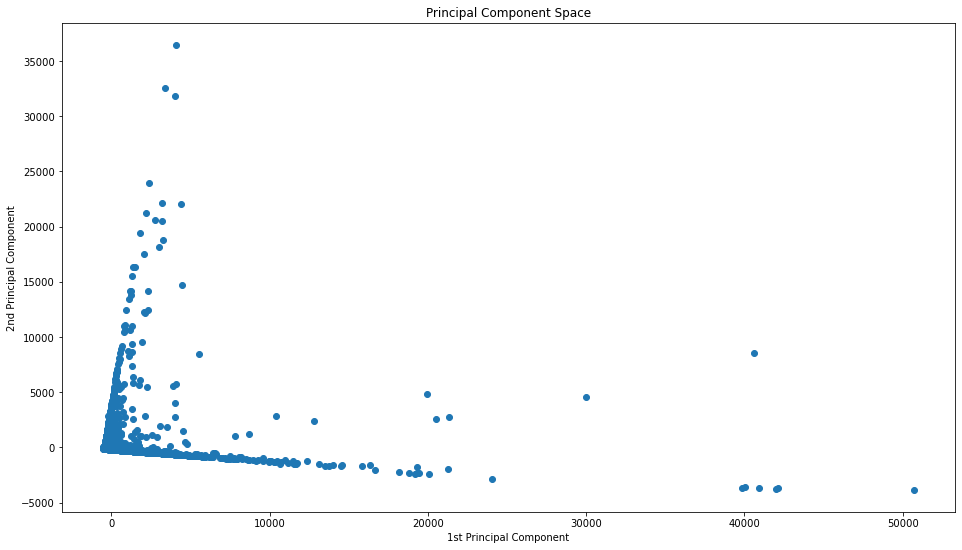

In [161]:
fig, ax = plt.subplots(figsize=(16,9))
ax.scatter(pca_space[:, 0], pca_space[:, 1])
ax.set_xlabel('1st Principal Component')
ax.set_ylabel('2nd Principal Component')
ax.set_title('Principal Component Space');

In [166]:
np.save(DATA_DIR / 'pca_space', pca_space)

In [162]:
import sklearn.manifold

In [163]:
tsne = sklearn.manifold.TSNE(
    n_components=2,
    metric='manhattan')

tsne_space = tsne.fit_transform(X_new)

/home/mmargenot/miniconda3/envs/virgil/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/mmargenot/miniconda3/envs/virgil/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/mmargenot/miniconda3/envs/virgil/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


In [170]:
y.round().unique()

array([4., 5., 3., 2.])

In [171]:
x_1, y_1 = tsne_space[(y.round() == 2.0), 0], tsne_space[(y.round() == 2.0), 1]
x_2, y_2 = tsne_space[(y.round() == 3.0), 0], tsne_space[(y.round() == 3.0), 1]
x_3, y_3 = tsne_space[(y.round() == 4.0), 0], tsne_space[(y.round() == 4.0), 1]
x_4, y_4 = tsne_space[(y.round() == 5.0), 0], tsne_space[(y.round() == 5.0), 1]

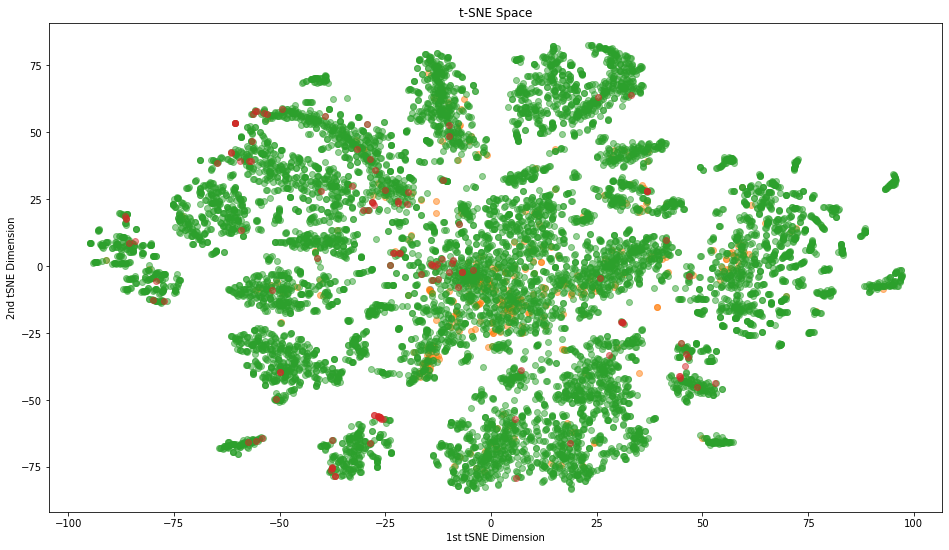

In [173]:
fig, ax = plt.subplots(figsize=(16,9))
ax.scatter(x_1, y_1, label='Avg Rating - 2', alpha=0.5)
ax.scatter(x_2, y_2, label='Avg Rating - 3', alpha=0.5)
ax.scatter(x_3, y_3, label='Avg Rating - 4', alpha=0.5)
ax.scatter(x_4, y_4, label='Avg Rating - 5', alpha=0.5)
ax.set_xlabel('1st tSNE Dimension')
ax.set_ylabel('2nd tSNE Dimension')
ax.set_title('t-SNE Space');

In [167]:
np.save(DATA_DIR / 'tsne_space', tsne_space)

In [ ]:
# segregate author dummies for PCA and tag counts for PCA separately


# Functions

In [ ]:
def build_useful_tags(book_tags, tags):
    # tags that at least 100 people have given to a any book
    useful_tag_ids = book_tags[
        book_tags['count'] > 100]['tag_id'].unique()
    
    filtered_tags = tags[tags['tag_id'].isin(useful_tag_ids)]
    
    tagged_books = book_tags.join(
        filtered_tags,
        on='tag_id',
        rsuffix='_user'
    ).dropna().drop(['tag_id', 'tag_id_user'], axis=1)
    
    tag_usage_counts = tagged_books.groupby(
        'tag_name'
    )['goodreads_book_id'].count()

    percs = tag_usage_counts.describe(
        percentiles=[0.01, 0.05, .25, .50, .75, .95, .99]).loc[['25%', '99%']]

    bottom = percs['25%']
    top = percs['99%']
    
    useful_tag_list = tag_usage_counts[
        (tag_usage_counts > bottom) &
        (tag_usage_counts < top)].index.tolist()
    
    return useful_tag_list

In [ ]:
def compute_pairwise_fuzz(tag_list):
    pairwise_fuzz = np.zeros(
        (len(useful_tag_list), len(useful_tag_list)))
    
    for i, ltag in tqdm.tqdm(
            enumerate(useful_tag_list),
            total=len(useful_tag_list)):
        for j, rtag in enumerate(useful_tag_list):
            pairwise_fuzz = pairwise_fuzz.at[i, j].set(
                fuzzywuzzy.fuzz.ratio(ltag, rtag))

    return pairwise_fuzz

In [ ]:
def cluster_tags(tag_list):
    try:
        pairwise_fuzz = load_cached_pairwise_fuzz()
    except:
        pairwise_fuzz = compute_pairwise_fuzz(tag_list)
        cach_pairwise_fuzz(pairwise_fuzz)
        
    hierarchy_clusters = sklearn.cluster.AgglomerativeClustering(
        n_clusters=15,
        linkage='ward')
    
    hierarchy_clusters.fit(pairwise_fuzz)
    
    return hierarchy_clusters